# LightGMB Iteration 2

- Using a smoothing window of 500

In [4]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

import warnings
warnings.filterwarnings('ignore')

In [5]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

In [6]:
train_df = pd.read_csv("./train.csv", dtype=dtypes, header=0)

In [94]:
test_df = pd.read_csv("./test.csv", dtype=dtypes, header=0)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867421 entries, 0 to 4867420
Data columns (total 28 columns):
crew          int8
experiment    category
time          float32
seat          int8
eeg_fp1       float32
eeg_f7        float32
eeg_f8        float32
eeg_t4        float32
eeg_t6        float32
eeg_t5        float32
eeg_t3        float32
eeg_fp2       float32
eeg_o1        float32
eeg_p3        float32
eeg_pz        float32
eeg_f3        float32
eeg_fz        float32
eeg_f4        float32
eeg_c4        float32
eeg_p4        float32
eeg_poz       float32
eeg_c3        float32
eeg_cz        float32
eeg_o2        float32
ecg           float32
r             float32
gsr           float32
event         category
dtypes: category(2), float32(24), int8(2)
memory usage: 464.2 MB


In [9]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [10]:
test_df.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [11]:
features_n = [
    "eeg_fp1",
    "eeg_f7",
    "eeg_f8",
    "eeg_t4",
    "eeg_t6",
    "eeg_t5",
    "eeg_t3",
    "eeg_fp2",
    "eeg_o1",
    "eeg_p3",
    "eeg_pz",
    "eeg_f3",
    "eeg_fz",
    "eeg_f4",
    "eeg_c4",
    "eeg_p4",
    "eeg_poz",
    "eeg_c3",
    "eeg_cz",
    "eeg_o2",
    "ecg",
    "r",
    "gsr"
]

In [12]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']

In [97]:
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']


In [14]:
print("Number of pilots : ", len(train_df['pilot'].unique()))


Number of pilots :  18


In [15]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,pilot
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A,101
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A,101
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A,101
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A,101
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A,101


### Smoothing Tests

In [17]:
test = train_df[train_df['pilot']==101]

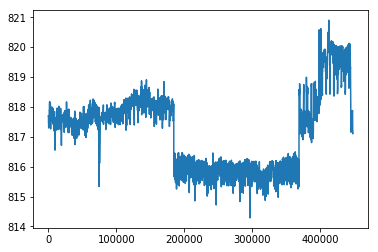

In [35]:
test['r'].plot.line()

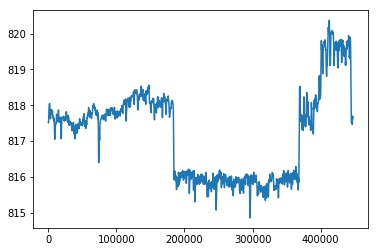

In [42]:
test['r'].rolling(500, center=True).mean().plot.line()

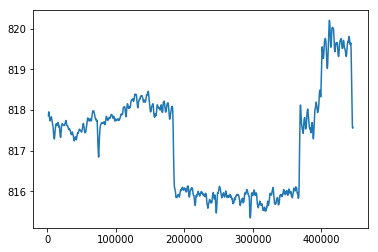

In [57]:
test['r'].rolling(1000, center=True).mean().plot.line()

## Apply normalisation and train

In [58]:
def smooth_data(df, features, window=500):
    pilots = df["pilot"].unique()
    for pilot in pilots:
        pilot_df = df[df['pilot']==pilot]
        ids = df[df["pilot"] == pilot].index
        for f in features:
            pilot_df[f] = pilot_df[f].rolling(window, center=True).mean()
        df.loc[ids] = pilot_df
    return df

In [59]:
def normalize_by_pilots(df):
    pilots = df["pilot"].unique()
    for pilot in pilots:
        ids = df[df["pilot"] == pilot].index
        scaler = MinMaxScaler()
        df.loc[ids, features_n] = scaler.fit_transform(df.loc[ids, features_n])
    return df

In [61]:
train_df = smooth_data(train_df, features_n)

/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [62]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,pilot
0,1,CA,0.011719,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,101
1,1,CA,0.015625,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,101
2,1,CA,0.019531,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,101
3,1,CA,0.023438,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,101
4,1,CA,0.027344,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,101


In [63]:
train_df.shape

(4867421, 29)

In [64]:
train_df = train_df.dropna(axis=0, how='any')

In [65]:
train_df.shape

(4858439, 29)

In [66]:
train_df = normalize_by_pilots(train_df)

/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/sklearn/pre

In [98]:
test_df_filled = test_df.copy()
test_df_filled = smooth_data(test_df_filled, features_n, window=500)
test_df_filled = test_df_filled.fillna(test_df)

/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [99]:
test_df_filled.shape

(17965143, 29)

In [103]:
test_df_filled.iloc[10000]

id              10000
crew                1
experiment       LOFT
time          1014.53
seat                0
eeg_fp1       -1.4793
eeg_f7        4.14624
eeg_f8        2.82785
eeg_t4        11.3342
eeg_t6        4.34168
eeg_t5        25.5625
eeg_t3        10.7835
eeg_fp2       1.98595
eeg_o1        4.59317
eeg_p3        4.90497
eeg_pz        -5.9499
eeg_f3        11.3906
eeg_fz        53.5564
eeg_f4        7.07675
eeg_c4        3.07169
eeg_p4        2.43666
eeg_poz       8.43333
eeg_c3        11.3948
eeg_cz        7.03506
eeg_o2        5.87196
ecg          -7782.25
r             640.683
gsr            578.54
pilot               1
Name: 10000, dtype: object

In [102]:
test_df.iloc[10000]

id              10000
crew                1
experiment       LOFT
time          1014.53
seat                0
eeg_fp1       34.0416
eeg_f7        16.6227
eeg_f8        22.9715
eeg_t4        31.1783
eeg_t6       -4.10478
eeg_t5        42.7379
eeg_t3        25.4899
eeg_fp2         29.75
eeg_o1        10.9593
eeg_p3        12.7813
eeg_pz        20.6947
eeg_f3        8.18007
eeg_fz        82.8158
eeg_f4        16.8611
eeg_c4        4.89996
eeg_p4        15.0652
eeg_poz       20.4056
eeg_c3        14.3188
eeg_cz        14.6192
eeg_o2        12.1898
ecg          -7830.43
r             640.332
gsr           578.866
pilot               1
Name: 10000, dtype: object

In [30]:
train_df.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,pilot
0,1,CA,0.011719,1,0.567917,0.581625,0.585034,0.595207,0.583200,0.605511,...,0.583052,0.581687,0.579501,0.457273,0.328979,0.421859,0.51701,0.327572,A,101
1,1,CA,0.015625,1,0.569223,0.582367,0.585134,0.599514,0.582847,0.603977,...,0.583970,0.581914,0.579852,0.464363,0.329875,0.421859,0.51701,0.327572,A,101
2,1,CA,0.019531,1,0.575215,0.583258,0.597190,0.613087,0.582929,0.604769,...,0.583969,0.583537,0.580340,0.464639,0.331117,0.421859,0.51701,0.327572,A,101
3,1,CA,0.023438,1,0.575572,0.581103,0.590878,0.607220,0.584998,0.604466,...,0.585729,0.583289,0.578917,0.465991,0.330220,0.421859,0.51701,0.327572,A,101
4,1,CA,0.027344,1,0.573665,0.581252,0.589745,0.604044,0.584669,0.603190,...,0.585541,0.583303,0.579360,0.464856,0.331273,0.421859,0.51701,0.327572,A,101


In [104]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['event']
)

In [105]:
print(f"Training on {train_df.shape[0]} samples.")

Training on 3886751 samples.


In [106]:
features = ["crew", "seat"] + features_n

In [107]:
def run_lgb(df_train, df_test):
    # Classes as integers
    dic = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    try:
        df_train["event"] = df_train["event"].apply(lambda x: dic[x])
        df_test["event"] = df_test["event"].apply(lambda x: dic[x])
    except:
        pass

    params = {"objective" : "multiclass",
              "num_class": 4,
              "metric" : "multi_error",
              "num_leaves" : 30,
              "min_child_weight" : 50,
              "learning_rate" : 0.1,
              "bagging_fraction" : 0.7,
              "feature_fraction" : 0.7,
              "bagging_seed" : 420,
              "verbosity" : -1
             }

    print(len(df_train["event"]), len(df_test["event"]))
    print(df_train["event"].shape, df_test["event"].shape)
    print(type(df_train["event"]), type(df_test["event"]))
    
    lg_train = lgb.Dataset(df_train[features], label=list(df_train["event"]))
    lg_test = lgb.Dataset(df_test[features], label=list(df_test["event"]))
    model = lgb.train(
        params,
        lg_train,
        1000,
        valid_sets=[lg_test],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    return model

In [108]:
model = run_lgb(train_df, val_df)

3886751 971688
(3886751,) (971688,)
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0654953
[200]	valid_0's multi_error: 0.0435737
[300]	valid_0's multi_error: 0.0297379
[400]	valid_0's multi_error: 0.0207886
[500]	valid_0's multi_error: 0.0147568
[600]	valid_0's multi_error: 0.010279
[700]	valid_0's multi_error: 0.00736965
[800]	valid_0's multi_error: 0.00512613
[900]	valid_0's multi_error: 0.00382633
[1000]	valid_0's multi_error: 0.00287953
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.00287953


ImportError: You must install matplotlib to plot importance.

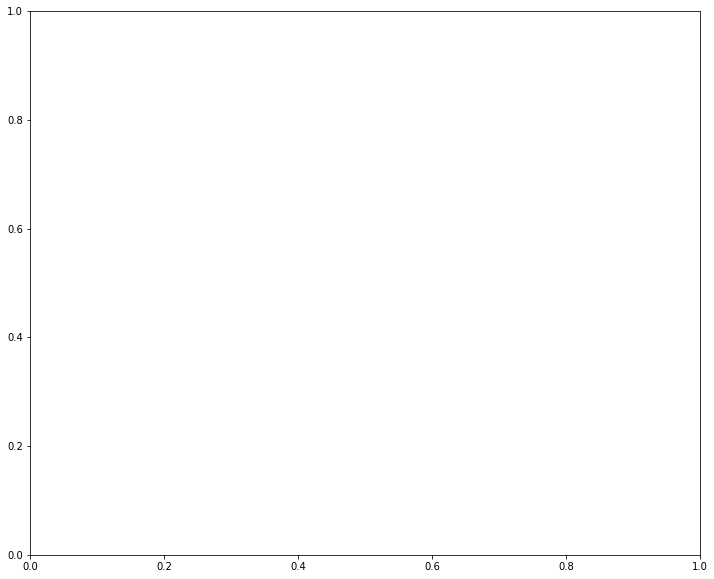

In [109]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, height=0.8, ax=ax)
ax.grid(False)
plt.ylabel('Feature', size=12)
plt.xlabel('Importance', size=12)
plt.title("Importance of the Features of our LightGBM Model", fontsize=15)
plt.show()

In [110]:
pred_val = model.predict(val_df[features], num_iteration=model.best_iteration)


/Users/harpalsahota/.local/share/virtualenvs/reducing_commercial_aviation_fatalities-bqjJ6FiO/lib/python3.6/site-packages/lightgbm/basic.py:469: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [111]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

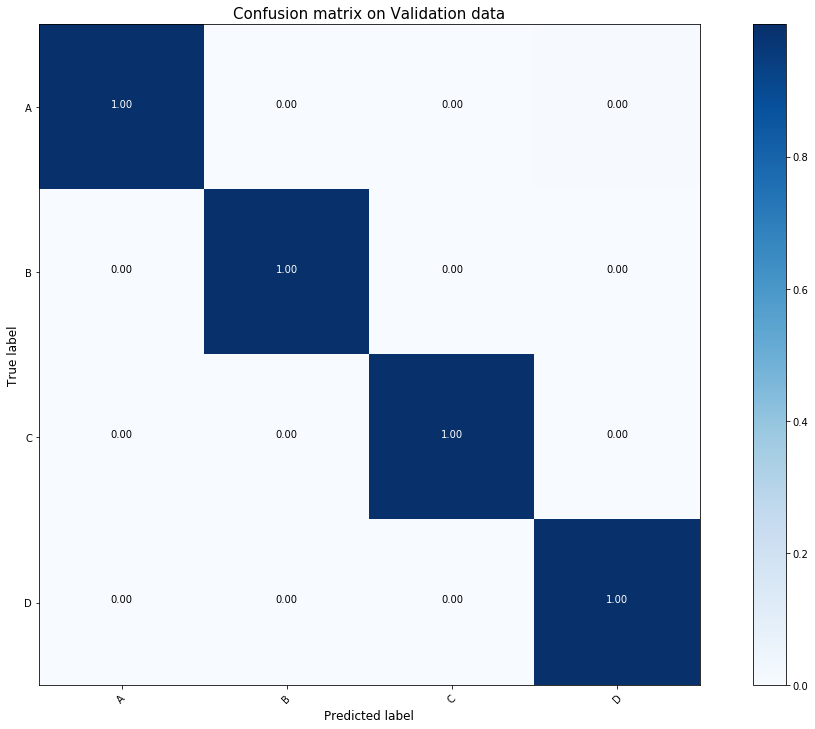

In [112]:
import itertools
conf_mat_val = confusion_matrix(np.argmax(pred_val, axis=1), val_df["event"].values)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

In [113]:
pred_test = model.predict(test_df_filled[features], num_iteration=model.best_iteration)

In [114]:
submission = pd.DataFrame(
    np.concatenate((np.arange(len(test_df))[:, np.newaxis], pred_test), axis=1), 
    columns=['id', 'A', 'B', 'C', 'D']
)

In [115]:
submission['id'] = submission['id'].astype(int)

In [116]:
submission.head()

,id,A,B,C,D
0,0,0.739619,0.158551,0.101823,6.742667e-06
1,1,0.673764,0.201247,0.124987,1.638031e-06
2,2,0.081563,0.705427,0.213009,7.671397e-07
3,3,0.693080,0.285534,0.021386,1.572101e-07
4,4,0.641928,0.170579,0.187474,1.872287e-05


In [119]:
submission.to_csv("lgbm_iter_2.csv", index=False, header=True)